In [1]:
import uproot
import awkward as ak
import numpy as np
import vector
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [2]:
# Open LHE file
with uproot.open("partons.root:events") as f:
    #print(f.keys())
    px = f['px'].array()
    py = f['py'].array()
    pz = f['pz'].array()
    e = f['energy'].array()
    m = f['mass'].array()
    pid = f['pid'].array()
    m1 = f['mother1'].array()
    m2 = f['mother2'].array()

# Extract electron 3 vector based on PID
mask_el = abs(pid)==11
true_el_px = px[mask_el]
true_el_py = py[mask_el]
true_el_pz = pz[mask_el]

# Extract muon 3 vector based on PID
mask_mu = abs(pid)==13
true_mu_px = px[mask_mu]
true_mu_py = py[mask_mu]
true_mu_pz = pz[mask_mu]

counts = ak.num(px)
mask = counts==11
print("Hard Processes with 11 Partons:  ", len(counts[mask]), " / ", len(px))

Hard Processes with 11 Partons:   1695  /  100000


In [3]:
Events_Electron = ak.any(abs(pid)==11, axis=1)
Events_Muon = ak.any(abs(pid)==13, axis=1)

In [10]:
with uproot.open("dataset.root:Delphes") as f:
    #print(f.keys())
    #jet_pt = f['ParticleFlowJet15/ParticleFlowJet15.PT'].array()
    #jet_eta = f['ParticleFlowJet15/ParticleFlowJet15.Eta'].array()
    #jet_phi = f['ParticleFlowJet15/ParticleFlowJet15.Phi'].array()
    
    reco_el_pt = f['Electron/Electron.PT'].array()
    reco_el_eta = f['Electron/Electron.Eta'].array()
    reco_el_phi = f['Electron/Electron.Phi'].array()
    
    reco_mu_pt = f['Muon/Muon.PT'].array()
    reco_mu_eta = f['Muon/Muon.Eta'].array()
    reco_mu_phi = f['Muon/Muon.Phi'].array()

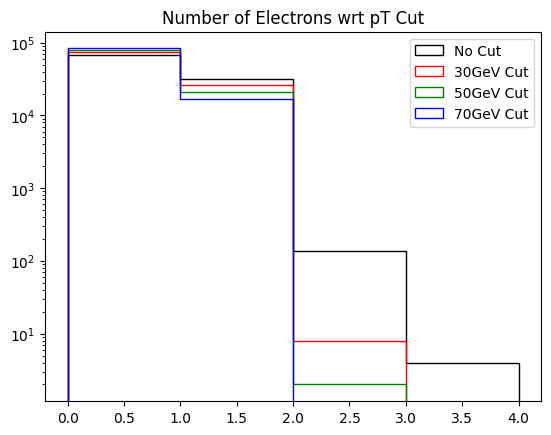

In [11]:
plt.title("Number of Electrons wrt pT Cut")
plt.hist(ak.num(reco_el_pt),histtype='step',color='k',bins=4,range=(0,4),label='No Cut')
plt.hist(ak.num(reco_el_pt[reco_el_pt>30]),color='r',histtype='step',bins=4,range=(0,4),label='30GeV Cut')
plt.hist(ak.num(reco_el_pt[reco_el_pt>50]),color='g',histtype='step',bins=4,range=(0,4),label='50GeV Cut')
plt.hist(ak.num(reco_el_pt[reco_el_pt>70]),color='b',histtype='step',bins=4,range=(0,4),label='70GeV Cut')
plt.yscale('log')
plt.legend()
plt.show()

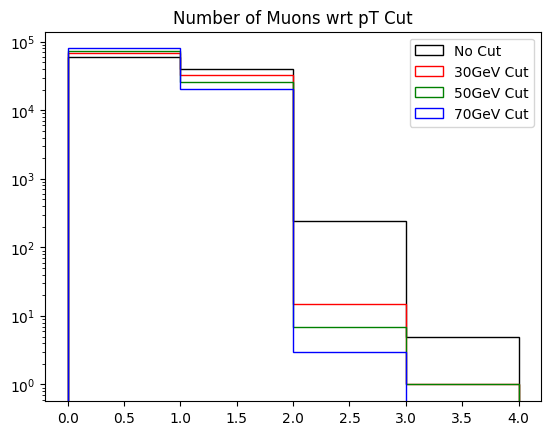

In [14]:
plt.title("Number of Muons wrt pT Cut")
plt.hist(ak.num(reco_mu_pt),histtype='step',color='k',bins=4,range=(0,4),label='No Cut')
plt.hist(ak.num(reco_mu_pt[reco_mu_pt>30]),color='r',histtype='step',bins=4,range=(0,4),label='30GeV Cut')
plt.hist(ak.num(reco_mu_pt[reco_mu_pt>50]),color='g',histtype='step',bins=4,range=(0,4),label='50GeV Cut')
plt.hist(ak.num(reco_mu_pt[reco_mu_pt>70]),color='b',histtype='step',bins=4,range=(0,4),label='70GeV Cut')
plt.yscale('log')
plt.legend()
plt.show()

In [8]:
# Initialize lists for plotting
pt_true_el = []
pt_reco_el = []
deltaR = []
deltaEta = []
deltaPhi = []

missing_el=0
not_el=0

# Loop over all events
num_events=len(true_el_px)
#num_events=10000
for i in range(num_events):
    
    if Events_Electron[i]==False:
        not_el+=1
        continue
    
    # Ensure only one truth object
    assert len(true_el_px[i])==1
    
    # Ensure at least one reco object
    if not ak.any(reco_el_pt[i]>0):
        missing_el+=1
        continue
        
    # Save truth object 3-Vector
    true_el = vector.MomentumObject3D(px=true_el_px[i][0], py=true_el_py[i][0], pz=true_el_pz[i][0])
    
    # Find closest candidate in deltaR
    delR = []
    for j in range(len(reco_el_pt[i])):
        delR.append(true_el.deltaR(vector.MomentumObject3D(pt=reco_el_pt[i][j], eta=reco_el_eta[i][j], phi=reco_el_phi[i][j])))
    argmin = np.argmin(delR)
    candidate = vector.MomentumObject3D(pt=reco_el_pt[i][argmin], eta=reco_el_eta[i][argmin], phi=reco_el_phi[i][argmin])
    
    # Closest candidate in deltaR is matched
    matched_el = candidate
    
    # Fill lists for plotting
    pt_true_el.append(true_el.pt)
    pt_reco_el.append(matched_el.pt)
    deltaR.append(true_el.deltaR(matched_el))
    deltaEta.append(true_el.deltaeta(matched_el))
    deltaPhi.append(true_el.deltaphi(matched_el))
    
print("Events with Truth Muons: ", not_el, "/", num_events)
print("Events without reco Electron: ", missing_el, "/", num_events-not_el)

Events with Truth Muons:  49839 / 100000
Events without reco Electron:  18083 / 50161


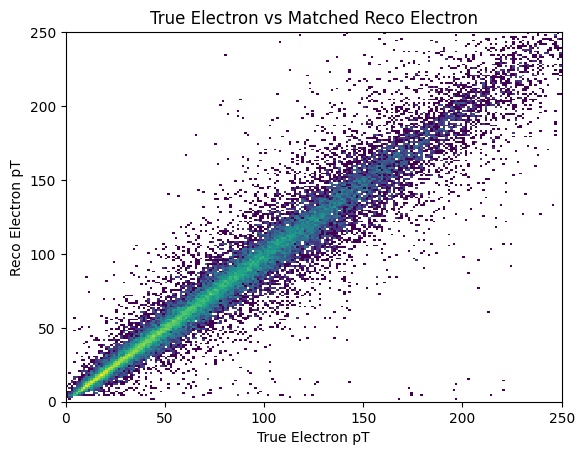

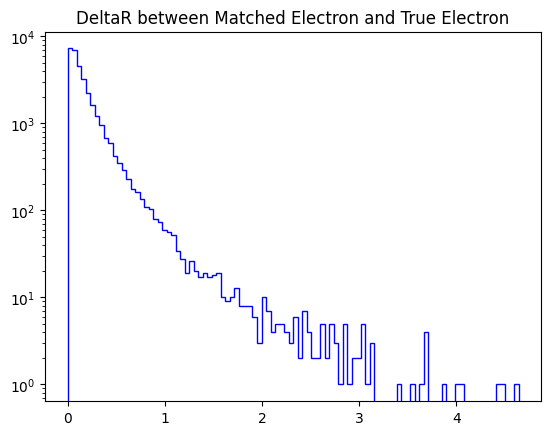

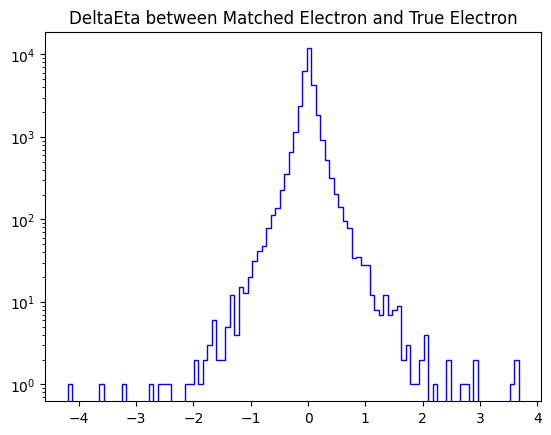

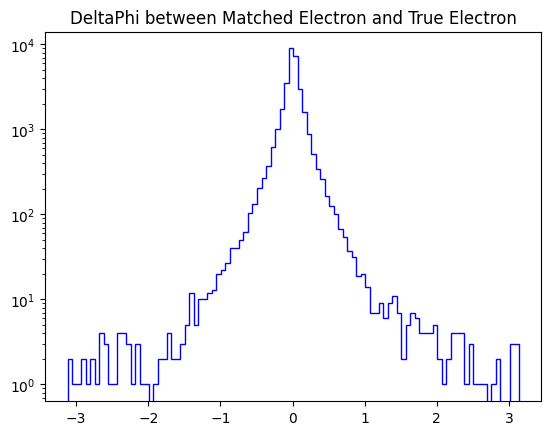

In [7]:
plt.title("True Electron vs Matched Reco Electron")
plt.hist2d(pt_true_el,pt_reco_el, bins=200,norm=mcolors.LogNorm(),range=((0,250),(0,250)))
plt.xlabel("True Electron pT")
plt.ylabel("Reco Electron pT")
plt.show()

plt.title("DeltaR between Matched Electron and True Electron")
plt.hist(deltaR,histtype='step',bins=100,color='b')
plt.yscale("log")
plt.show()

plt.title("DeltaEta between Matched Electron and True Electron")
plt.hist(deltaEta,histtype='step',bins=100,color='b')
plt.yscale("log")
plt.show()

plt.title("DeltaPhi between Matched Electron and True Electron")
plt.hist(deltaPhi,histtype='step',bins=100,color='b')
plt.yscale("log")
plt.show()

In [17]:
# Initialize lists for plotting
pt_true_mu = []
pt_reco_mu = []
deltaR = []
deltaEta = []
deltaPhi = []

missing_mu=0
not_mu=0

# Loop over all events
num_events=len(true_mu_px)
#num_events=10000
for i in range(num_events):
    
    if Events_Muon[i]==False:
        not_mu+=1
        continue
    
    # Ensure only one truth object
    assert len(true_mu_px[i])==1
    
    # Ensure at least one reco object
    if not ak.any(reco_mu_pt[i]>0):
        missing_mu+=1
        continue
        
    # Save truth object 3-Vector
    true_mu = vector.MomentumObject3D(px=true_mu_px[i][0], py=true_mu_py[i][0], pz=true_mu_pz[i][0])
    
    # Find closest candidate in deltaR
    delR = []
    for j in range(len(reco_mu_pt[i])):
        delR.append(true_mu.deltaR(vector.MomentumObject3D(pt=reco_mu_pt[i][j], eta=reco_mu_eta[i][j], phi=reco_mu_phi[i][j])))
    argmin = np.argmin(delR)
    candidate = vector.MomentumObject3D(pt=reco_mu_pt[i][argmin], eta=reco_mu_eta[i][argmin], phi=reco_mu_phi[i][argmin])
    
    # Closest candidate in deltaR is matched
    matched_mu = candidate
    
    # Fill lists for plotting
    pt_true_mu.append(true_mu.pt)
    pt_reco_mu.append(matched_mu.pt)
    deltaR.append(true_mu.deltaR(matched_mu))
    deltaEta.append(true_mu.deltaeta(matched_mu))
    deltaPhi.append(true_mu.deltaphi(matched_mu))
    
print("Events with Truth Electrons: ", not_mu, "/", num_events)
print("Events without reco Muon: ", missing_mu, "/", num_events-not_mu)

Events with Truth Electrons:  50161 / 100000
Events without reco Muon:  10280 / 49839


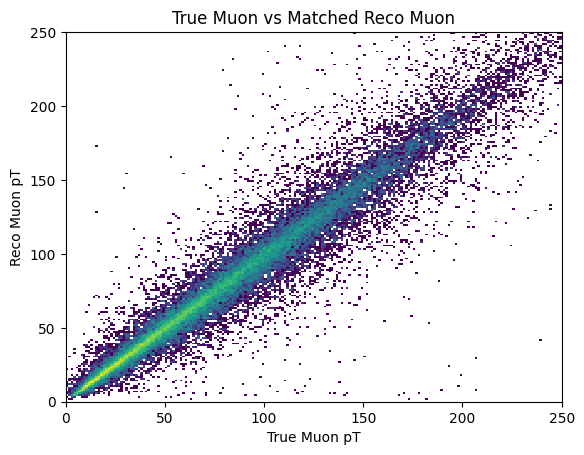

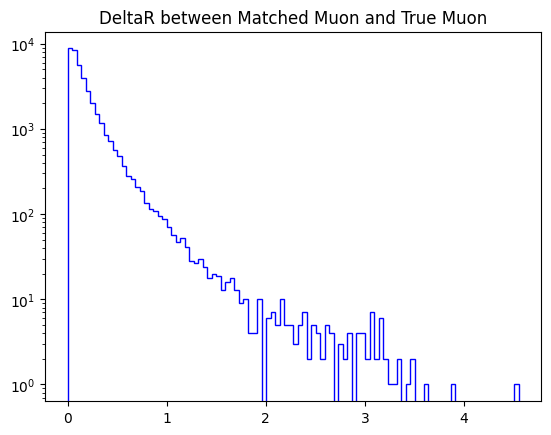

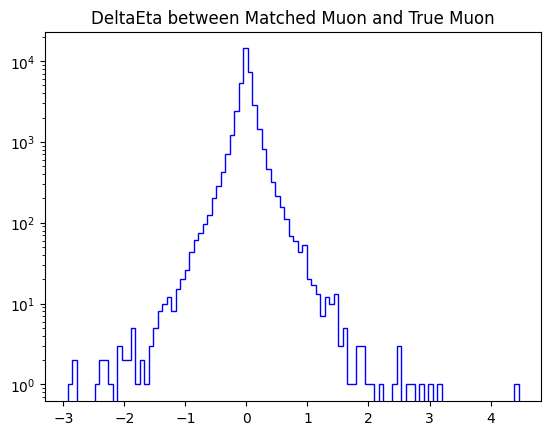

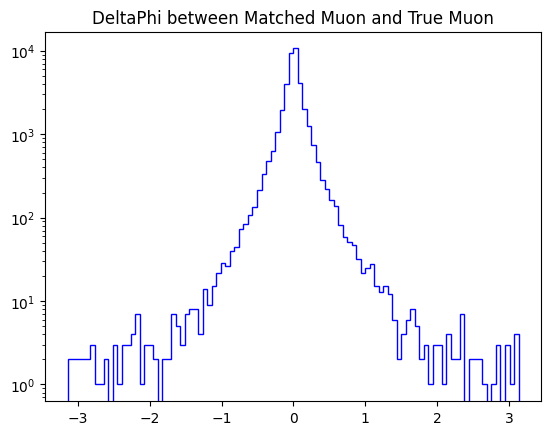

In [18]:
plt.title("True Muon vs Matched Reco Muon")
plt.hist2d(pt_true_mu,pt_reco_mu, bins=200,norm=mcolors.LogNorm(),range=((0,250),(0,250)))
plt.xlabel("True Muon pT")
plt.ylabel("Reco Muon pT")
plt.show()

plt.title("DeltaR between Matched Muon and True Muon")
plt.hist(deltaR,histtype='step',bins=100,color='b')
plt.yscale("log")
plt.show()

plt.title("DeltaEta between Matched Muon and True Muon")
plt.hist(deltaEta,histtype='step',bins=100,color='b')
plt.yscale("log")
plt.show()

plt.title("DeltaPhi between Matched Muon and True Muon")
plt.hist(deltaPhi,histtype='step',bins=100,color='b')
plt.yscale("log")
plt.show()